# Wisconsin Diagnostic Breast Cancer (WDBC)
### UC Irvine Machine Learning Repository

**Dataset Description**

1. ID number
2. Diagnosis (M = malignant, B = benign)

3-32

Ten real-valued features are computed for each cell nucleus:

a. **Radius** (mean of distances from center to points on the perimeter)  
b. **Texture** (standard deviation of gray-scale values)  
c. **Perimeter**  
d. **Area**  
e. **Smoothness** (local variation in radius lengths)  
f. **Compactness** (perimeter² / area - 1.0)  
g. **Concavity** (severity of concave portions of the contour)  
h. **Concave points** (number of concave portions of the contour)  
i. **Symmetry**  
j. **Fractal dimension** ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

## Environment Setup

In [24]:
# Standard libraries
import warnings

import numpy as np
import pandas as pd

# Scikit-learn imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Custom modules
from data_loader import DataLoader
from model_optimizer import ModelOptimizer
from model_saver import ModelSaver
from model_trainer import ModelTrainer
from pipeline_trainer import PipelineTrainer
from preprocessor import Preprocessor

# Suppress any unnecessary warnings
warnings.filterwarnings("ignore")

In [2]:
# DataLoader parameters
URL = 'https://raw.githubusercontent.com/FernandoMiyazaki/puc-rio-mvp2-qualidade-seguranca-sistemas-inteligentes/main/api/machine_learning/notebooks/wdbc.data'
DELIMITER = ','
COLUMN_NAMES = [
    'id_number',
    'diagnosis',
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'smoothness_mean',
    'compactness_mean',
    'concavity_mean',
    'concave_points_mean',
    'symmetry_mean',
    'fractal_dimension_mean',
    'radius_se',
    'texture_se',
    'perimeter_se',
    'area_se',
    'smoothness_se',
    'compactness_se',
    'concavity_se',
    'concave_points_se',
    'symmetry_se',
    'fractal_dimension_se',
    'radius_worst',
    'texture_worst',
    'perimeter_worst',
    'area_worst',
    'smoothness_worst',
    'compactness_worst',
    'concavity_worst',
    'concave_points_worst',
    'symmetry_worst',
    'fractal_dimension_worst'
]

# Preprocessor parameters
TARGET_COLUMN = 'diagnosis'
CORR_THRESHOLD = 0.7

# Train-Test split parameters
TEST_SIZE = 0.2
SEED = 7

# ModelTrainer parameters
SCORING = 'accuracy'
N_SPLITS = 10

## Loading Data

In [3]:
# Initializing the DataLoader
data_loader = DataLoader(
    url=URL,
    delimiter=DELIMITER, 
    column_names=COLUMN_NAMES
)

# Load the dataset using the DataLoader instance
df = data_loader.load_data()

In [4]:
# Inspecting the data structure and verifying the load
df.head()

,id_number,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Display concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_number                569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Every column has 569 non-null values, indicating that there are no missing values in this dataset. No immediate need for imputation or handling missing data. 'diagnosis' column is a categorical column and must be converted into a numerical column. Also, with 30 numerical columns, there could be high multicollinearity (i.e., some features being highly correlated), so a feature selection process should be applied.

## Preprocessing the data

In [6]:
# Initializing the Preprocessor
preprocessor = Preprocessor(
    df, 
    target_column=TARGET_COLUMN, 
    corr_threshold=CORR_THRESHOLD
)

# Perform preprocessing on the DataFrame and return the processed data
df = preprocessor.preprocess()

In [7]:
# Inspecting the data structure and verifying the preprocessed data
df.head()

,concave_points_worst,perimeter_worst,concave_points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,diagnosis
0,0.2654,184.60,0.14710,25.38,122.80,2019.0,17.99,1001.0,1
1,0.1860,158.80,0.07017,24.99,132.90,1956.0,20.57,1326.0,1
2,0.2430,152.50,0.12790,23.57,130.00,1709.0,19.69,1203.0,1
3,0.2575,98.87,0.10520,14.91,77.58,567.7,11.42,386.1,1
4,0.1625,152.20,0.10430,22.54,135.10,1575.0,20.29,1297.0,1


In [8]:
# Display concise summary of the preprocessed DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   concave_points_worst  569 non-null    float64
 1   perimeter_worst       569 non-null    float64
 2   concave_points_mean   569 non-null    float64
 3   radius_worst          569 non-null    float64
 4   perimeter_mean        569 non-null    float64
 5   area_worst            569 non-null    float64
 6   radius_mean           569 non-null    float64
 7   area_mean             569 non-null    float64
 8   diagnosis             569 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 40.1 KB


## Train-Test Split for Evaluating Machine Learning Models

In [9]:
# Separate the features and the target variable
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED
)

## Cross-Validation with Stratification

In [10]:
# Initialize StratifiedKFold for cross-validation
kfold = StratifiedKFold(
    n_splits=N_SPLITS, 
    shuffle=True, 
    random_state=SEED
)

## Modeling and Inference

### Model Creation and Evaluation: Baseline

KNN: 0.9318357487922706 (0.02309810315264349)
CART: 0.9274879227053141 (0.038989697408449174)
NB: 0.9209178743961353 (0.03414953259137642)
SVM: 0.9098550724637681 (0.02682895377431852)


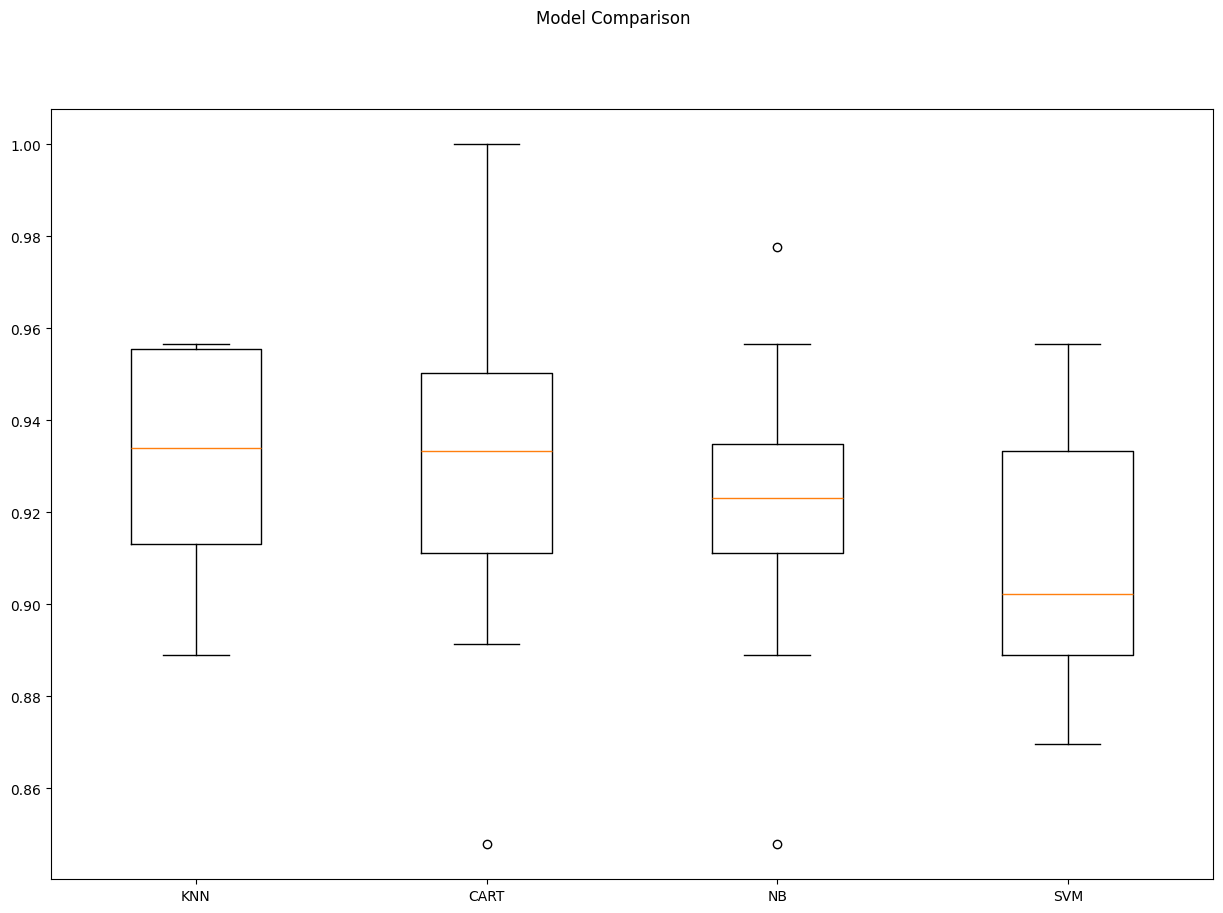

In [11]:
# Get default models for training
models = ModelTrainer._default_models()

# Initialize the ModelTrainer
model_trainer = ModelTrainer(
    X_train=X_train, 
    y_train=y_train, 
    models=models, 
    scoring=SCORING, 
    kfold=kfold
)

# Evaluate the performance of the models
model_trainer.evaluate_models()

* KNN has the highest accuracy among the models with a low standard deviation, indicating both high performance and consistency.
* CART follows with slightly lower accuracy and higher variability compared to KNN.
* Naive Bayes performs slightly worse than CART but maintains reasonable stability.
* SVM has the lowest accuracy among the models, although its performance is still relatively stable.

### Model Creation and Evaluation: Standardized and Normalized Data

KNN-orig: 0.9318357487922706 (0.02309810315264349)
CART-orig: 0.92743961352657 (0.040491507547651635)
NB-orig: 0.9209178743961353 (0.03414953259137642)
SVM-orig: 0.9098550724637681 (0.02682895377431852)
KNN-std: 0.9517391304347825 (0.025323826322407508)
CART-std: 0.9297101449275363 (0.037437743447139994)
NB-std: 0.9318840579710145 (0.040788512723474044)
SVM-std: 0.9472463768115942 (0.024528316519466704)
KNN-norm: 0.9517391304347826 (0.021266411610407196)
CART-norm: 0.9339613526570048 (0.035601636018576945)
NB-norm: 0.9318840579710145 (0.040788512723474044)
SVM-norm: 0.9516425120772947 (0.023636422796714227)


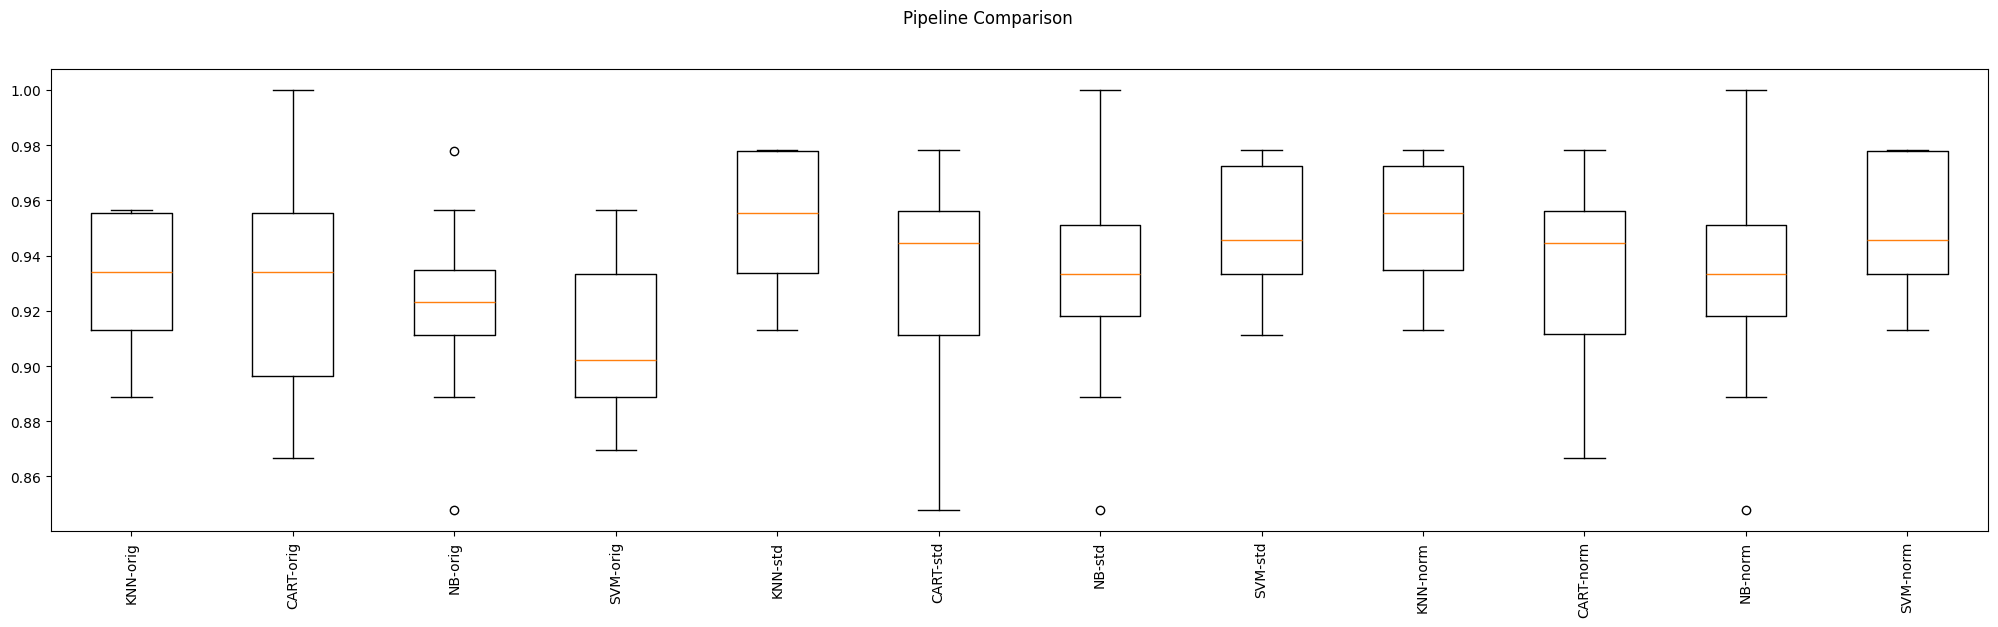

In [12]:
# Initialize the PipelineTrainer with training data and cross-validation strategy
pipeline_trainer = PipelineTrainer(
    X_train, 
    y_train,
    kfold=kfold
)

# Execute the pipelines using the PipelineTrainer
pipeline_trainer.run_pipelines()

KNN with MinMaxScaler (KNN-norm) is the best model based on these results. It has the highest mean accuracy and the lowest standard deviation, suggesting both excellent performance and stability.

## Hyperparameter Optimization

In [13]:
# Initialize the model optimizer with training data
optimizer = ModelOptimizer(X_train=X_train, y_train=y_train)

# Run the optimization process to find the best models
optimizer.optimize_models()

Model: KNN-orig - Best Score: 0.9318681318681319 using {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 3}
Model: KNN-std - Best Score: 0.9538461538461538 using {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Model: KNN-norm - Best Score: 0.9538461538461538 using {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Model: CART-orig - Best Score: 0.9318681318681318 using {'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Model: CART-std - Best Score: 0.9318681318681319 using {'CART__max_depth': None, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Model: CART-norm - Best Score: 0.9318681318681319 using {'CART__max_depth': 10, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Model: NB-orig - Best Score: 0.923076923076923 using {'NB__var_smoothing': 1e-09}
Model: NB-std - Best Score: 0.9362637362637363 using {'NB__var_smoothing': 1e-09}
Model: NB-norm - Best Score: 0.9362637362637363 using {'NB__var_smoothing': 1e-09}
Model: SVM-o

Although KNN-norm has the best performance, after hyperparameter optimization SVM-std and SVM-norm provided the highest accuracy (0.9648). Given that SVM models performed the best in hyperparameter optimization and have the highest scores, either of these two configurations would be the best choice for predicting breast cancer. We will use the following:

Model: SVM-std - {'SVM__C': 100, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}

## Assessing Model Performance

In [14]:
# Set the random seed for reproducibility
np.random.seed(7)

# Standardize the training data
scaler = StandardScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)

# Initialize and train the SVM model
model = SVC(
    C=100, 
    gamma=0.01, 
    kernel='rbf'
)
model.fit(rescaled_X_train, y_train)

# Standardize the test data
rescaled_X_test = scaler.transform(X_test)

# Make predictions and evaluate the model
predictions = model.predict(rescaled_X_test)
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.9473684210526315


Executing the model from a pipeline with optimized hyperparameters:

In [15]:
# Set seed for reproducibility
np.random.seed(7)

# Create a pipeline that standardizes the data and then applies the SVC model
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', model)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
predictions = pipeline.predict(X_test)

# Evaluate and print the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9473684210526315


## Saving the Model Files

In [16]:
# Save the trained Support Vector Classifier (SVC) model
ModelSaver.save_model(model, 'svc_breast_cancer_classi.pkl')

# Save the StandardScaler used for data standardization
ModelSaver.save_scaler(scaler, 'standard_scaler_breast_cancer.pkl')

# Save the entire pipeline, which includes both the scaler and the model
ModelSaver.save_pipeline(pipeline, 'svc_breast_cancer_pipeline.pkl')

# Save the test data and corresponding labels for future reference
ModelSaver.save_test_data(X_test, y_test, df)

## Applying the Model to New Data

In [17]:
# Initialize the StandardScaler and fit it to the entire dataset
scaler = StandardScaler().fit(X)

# Transform the entire dataset using the fitted scaler
rescaled_X = scaler.transform(X)

# Fit the model using the rescaled dataset
model.fit(rescaled_X, y)

SVC(C=100, gamma=0.01)

In [37]:
# Define new data (without known classes)
data = {
    'concave_points_worst': [0.217300, 0.248800, 0.128801],
    'perimeter_worst': [139.80, 189.80, 99.71],
    'concave_points_mean': [0.112800, 0.104980, 0.047811],
    'radius_worst': [21.960, 25.320, 15.111],
    'perimeter_mean': [105.10, 120.00, 87.41],
    'area_worst': [1396.0, 2598.0, 711.1],
    'radius_mean': [18.130, 16.810, 13.541],
    'area_mean': [898.8, 1060.0, 566.1]
}

# Define attribute names
attributes = [
    'concave_points_worst',
    'perimeter_worst',
    'concave_points_mean',
    'radius_worst',
    'perimeter_mean',
    'area_worst',
    'radius_mean',
    'area_mean'
]

# Create a DataFrame from the new data
input_data = pd.DataFrame(data, columns=attributes)

# Convert DataFrame to numpy array and extract features
array_input = input_data.values
X_input = array_input[:, 0:len(attributes)].astype(float)

# Standardize the new data using the previously fitted scaler
rescaled_input = scaler.transform(X_input)

# Print the rescaled input data
print(rescaled_input)

[[ 1.56367679  0.96919506  1.64774162  1.17846737  0.54086714  0.90605787
   1.13682597  0.69370762]
 [ 2.04331461  2.45848698  1.44603268  1.87426467  1.15460113  3.01906895
   0.76192723  1.15217696]
 [ 0.21613815 -0.2249192  -0.02858349 -0.23984088 -0.1877875  -0.29793655
  -0.16651518 -0.25252532]]


In [38]:
# Predicting class labels for the input data
predicted_classes = model.predict(rescaled_input)

# Display the predicted class labels
print(predicted_classes)

[1 1 0]
